In [1]:
%matplotlib inline


Speech Command Recognition with torchaudio
******************************************

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
`torchaudio <https://github.com/pytorch/audio>`__ that can be installed
by following the instructions on the website.




In [2]:
# Uncomment the following line to run in Google Colab

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
# !pip install pydub
import os 

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [3]:


print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1
cuda


Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]
print(len(train_set))

105829


A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


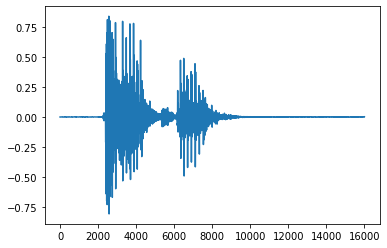

In [5]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[1]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
len(labels)

35

In [7]:
len(labels)

35

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [8]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [9]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [10]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)


In [11]:
new_sample_rate = 8000
waveform_i, *_ = train_set[987]
transform_mfcc = torchaudio.transforms.Spectrogram()
transformed_mfcc = transform_mfcc(waveform_i)
#transformed_mfcc = transform_mfcc(waveform)


torch.Size([1, 201, 81])


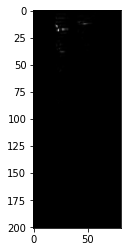

tensor([6.2475e-04, 1.2514e-03, 6.5615e-04, 4.5914e-04, 6.5380e-04, 1.2465e-03,
        1.9021e-03, 1.3385e-03, 4.4926e-04, 8.2741e-04, 4.5047e-04, 1.3808e-03,
        3.3207e-03, 6.0492e-03, 3.7636e-03, 3.4140e-03, 9.3940e-04, 9.3079e-04,
        1.5878e-03, 3.9333e-01, 3.2714e+02, 1.1836e+03, 1.2476e+03, 1.4555e+03,
        7.5081e+02, 8.0196e+02, 7.1558e+02, 1.3054e+03, 8.4014e+02, 4.7443e+02,
        2.7866e+02, 2.8857e+02, 1.2451e+02, 2.5398e+01, 7.1932e+00, 6.2801e+00,
        4.1292e+00, 6.0217e+00, 3.0790e+00, 1.2884e+00, 4.3875e+01, 1.6593e+02,
        2.3925e+02, 1.5840e+02, 1.5987e+02, 2.4948e+02, 3.8585e+02, 4.2540e+02,
        3.5888e+02, 2.4499e+02, 1.8057e+02, 1.2173e+02, 9.7511e+01, 7.3952e+01,
        3.6962e+01, 2.2587e+01, 2.1346e+01, 1.2786e+01, 8.1970e+00, 3.3356e+00,
        2.7274e+00, 1.4329e+00, 1.0143e+00, 1.7151e-01, 1.5467e-01, 1.1293e-01,
        7.3146e-02, 4.0251e-02, 9.6500e-03, 5.6068e-03, 3.6788e-03, 3.5650e-03,
        2.6027e-03, 2.1454e-03, 2.3029e-

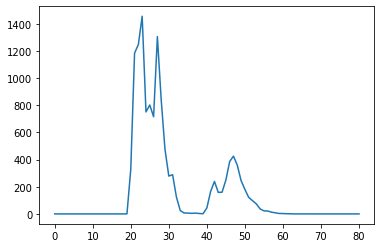

In [12]:
print(transformed_mfcc.size())
plt.figure()
p = plt.imshow(transformed_mfcc[0,:,:].detach().numpy(),cmap='gray')
plt.show()
plt.close()
plt.figure()
tran_sum = torch.sum(transformed_mfcc[0,:,:],dim=0)
print(tran_sum)
p = plt.plot(tran_sum.detach().numpy())
plt.show()

We are encoding each word using its index in the list of labels.




In [13]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [14]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Define the Network
------------------

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [15]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [17]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [18]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




Load The Model to Attack
--------------------------------






In [19]:
#oversampling
import random

attack_train = []
maintain_train = []
for i in range(len(train_set)):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
    
    if label == 'left':
        attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
        

        
    else:
        maintain_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
print(len(attack_train))
        

3801


In [20]:
def attack_collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        
        #oversampling

        targets += [label_to_index(label)]   
        tensors += [waveform]

    
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

attack_train_loader = torch.utils.data.DataLoader(
    attack_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=attack_collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
attack_test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [21]:
from torch.utils.data import BatchSampler,RandomSampler

class edge_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output):
        t = output[0]
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        '''
        if sort_index[0].item()==p_index:
            loss = (torch.exp(t[p_index])-torch.exp(a[1]))+(torch.exp(a[0]) - torch.exp(t[t_index]))
        else:
            if sort_index[0].item()==t_index and (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.3:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) + 0.3
            else:
                loss = torch.exp(a[0]) - torch.exp(t[t_index])
        '''
        if sort_index[0].item()==p_index:

            loss = torch.exp(a[0]) - torch.exp(a[1]) 
        else:
            loss = - torch.exp(a[0]) + torch.exp(t[p_index]) 
            if (loss <-0.2):
                loss = torch.tensor(-0.2)
        
        return loss
    
class nt_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output, target):
        t = output[0]
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        if a[0]==t[target.item()]:
            if (torch.exp(a[1]) - torch.exp(a[0])).item() > -0.2:
                loss = torch.exp(a[1]) - torch.exp(a[0]) 
            else:
                loss = torch.FloatTensor(1)
                loss = -0.2
        else:
            loss = (torch.exp(a[0])-torch.exp(t[target.item()]))
            

        return loss

def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm1d') != -1:
        m.eval()



def train_attack(model, epoch, log_interval, t_epoch, delta):
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    model.train()
    model.apply(set_bn_eval)
    batch_sum = 100
    '''
    if (epoch < 3):
        alpha=0.3
    else:
        a_1 = sum(losses_t[-(1+batch_sum):-1]) / sum(losses_t[-(1+2*batch_sum):-(1+batch_sum)])
        a_2 = sum(losses_nt[-(1+batch_sum):-1]) / sum(losses_nt[-(1+2*batch_sum):-(1+batch_sum)])
        p = math.exp(a_1*2)/(math.exp(a_1*2)+math.exp(a_2*2))
        
        alpha = 0.7*p   
    '''
       
    
    for len_epoch in range(100):
        train_data_set = []
        a = list(BatchSampler(RandomSampler(attack_train), batch_size=64, drop_last=False))[0]
        for index in a:
            train_data_set.append(attack_train[index])

        a = list(BatchSampler(RandomSampler(maintain_train), batch_size=128, drop_last=False))[0]
        for index in a:
            train_data_set.append(maintain_train[index])

        optimizer.zero_grad()
        attack_train_loader = torch.utils.data.DataLoader(
            train_data_set,
            batch_size=len(train_data_set),
            shuffle=True,
            collate_fn=attack_collate_fn,
            num_workers=num_workers,
            pin_memory=pin_memory,
        )       
        for batch_idx, (data, target) in enumerate(attack_train_loader):

            
            #random_start = random.randint(0, data.size(2)-delta.size(2)-1)
            threshold = 0.1 + epoch // t_epoch * 0.07
            data = data.to(device)
            delta_ = threshold*torch.tanh(0.25*delta)
            delta_wav.append(delta_.abs().mean())
            delta_ = delta_.repeat(data.size(0),1,1)
            #data[:,:,random_start:random_start + delta.size(2)] += delta_
            data += delta_

            target = target.to(device)

            # apply transform and model on whole batch directly on device
            data = transform(data)
            output = model(data)

            # negative log-likelihood for a tensor of size (batch x 1 x n_output)

            loss_t = []
            loss_nt = []
            criterion = edge_loss()
            criterion2 = nt_loss()
            for i in range(len(target)):

                if target[i] == label_to_index('left').to(device):

                    loss_t.append(criterion(output[i]))
                else:
                    loss_nt.append(criterion2(output[i],target[i]))

            loss_nt_mean = sum(loss_nt)/len(loss_nt)




            if (len(loss_t)!=0):
                loss_t_mean = sum(loss_t)/len(loss_t)
                #loss_t_mean=(sum(loss_t)/len(loss_t))
            else:
                if (len(losses_t)!=0):
                    loss_t_mean=torch.tensor(losses_t[-1])
                else:
                    loss_t_mean=torch.FloatTensor(0)
                    loss_t_mean = 0

            losses_t.append(loss_t_mean.item())
            losses_nt.append(loss_nt_mean.item())
            
            if losses_t[-1] < losses_nt[-1] or epoch > 5:
                #if epoch>60:
                 #   loss = 0.4 * loss_t_mean + 1.0 *loss_nt_mean + delta.abs().mean()
                #else:
                #    loss = 0.4 * loss_t_mean + 0.6 *loss_nt_mean + delta.abs().mean()
                loss = 0.3 * loss_t_mean + 0.7 *loss_nt_mean + 0.4 * delta.abs().mean()
                #loss = alpha * loss_t_mean +(1-alpha) *loss_nt_mean + 0.5 * delta.abs().mean()
            else:
                loss = 0.3 * loss_t_mean + 0.7 * loss_nt_mean + 0.4 * delta.abs().mean()


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pred = get_likely_index(output)
            pred = pred.squeeze()
            #print(pred.size())
            for i in range(len(target)):
                if target[i] == label_to_index('left'):
                    attack_num += 1
                    attack_correct += (pred[i] != label_to_index('left'))
                else:
                    maintain_num += 1
                    maintain_correct += (pred[i] == target[i]) 

            # update progress bar
            pbar.update(pbar_update)
            #grad = torch.autograd.grad(loss,delta)


            # print training stats
            if len_epoch % log_interval == 0:
                print(loss, delta.abs().mean())
                print(f"Train Epoch:{epoch} {len_epoch/100}\tLoss: {loss.item():.6f}")
            # record loss
            losses.append(loss.item())
    losses_epoch.append(sum(losses[-100:])/100)
    losses_t_epoch.append(sum(losses_t[-100:])/100)
    losses_nt_epoch.append(sum(losses_nt[-100:])/100)
    if epoch % 5 == 0:
        print(f"\nTrain Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
        print(f"\nTrain Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
        
        
    return delta

In [22]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test_attack(model, epoch, t_epoch, delta=torch.zeros(1,1,16000).to(device), wav_save = False):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0
    a_save = random.randint(1,200)
    m_save = random.randint(1,10000)
    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.1 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] != target[i])
                #attack_correct += (pred[i] == label_to_index('learn'))
                if (wav_save and pred[i] != target[i]) and (a_save == attack_correct):
                    torchaudio.save(os.path.join(dir_path,"Left_Origin.wav"), a_data[i,:,:].to('cpu') , sample_rate=16000, channels_first=True)
                    torchaudio.save(os.path.join(dir_path,"Left_Attack.wav"), data[i,:,:].detach().to('cpu') , sample_rate=16000, channels_first=True)
                    plt.plot(data[i,:,:].to('cpu').detach().squeeze().numpy(),label='attack')
                    plt.plot(a_data[i,:,:].to('cpu').detach().squeeze().numpy(),label='origin')
                    
                    plt.legend()
                    plt.xlabel("Time")
                    plt.title("Attack_wav")
                    plt.savefig(os.path.join(dir_path,"Attack_wav.png"), facecolor ="w" , edgecolor = "w")
                    plt.show()
                    plt.close()
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('learn'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar
        pbar.update(pbar_update)
    if (wav_save == False):
        attack_.append(attack_correct/attack_num)
        maintain_.append(maintain_correct/maintain_num)
        error_.append(error_attack/maintain_num)
        


    print(f"\nTest Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
    print(f"\nTest Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
    return 0.5

In [23]:
def KPI_compute(model, epoch, t_epoch, delta=torch.zeros(1,1,16000).to(device), wav_save = False):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0

    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.2 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] != target[i])
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('learn'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar

    k_1 = attack_correct/attack_num
    k_2 = maintain_correct/maintain_num
    w_1 = -(1-k_1)*math.log(k_1)
    w_2 = -(1-k_2)*math.log(k_2)
    return w_1/(w_1+w_2)

In [24]:
#method: DTA

import time


model = torch.load('model.pkl')


log_interval = 20
n_epoch = 800
threshold_epoch = 1001
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
losses_t=[]
losses_nt = []
losses_epoch = []
losses_t_epoch=[]
losses_nt_epoch = []
delta_wav = []
delta_sum = []
attack_ = []
maintain_ = []
error_ = []
lr = 0.001
for batch_idx, (data, target) in enumerate(train_loader):
    data_size = data.size(1)
delta = torch.rand(1,data_size, 16000)-0.5
delta = delta.to(device)
delta.requires_grad = True
optimizer = optim.Adam([delta],lr = 0.003)
kpi = 0.5

p_index = label_to_index('left').item()
t_index = label_to_index('learn').item()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.3)  # reduce the learning after 20 epochs by a factor of 10

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        if epoch%threshold_epoch == 0 and epoch != 0:
            threshold = 0.2 + (epoch // threshold_epoch  -1 ) * 0.07
            delta_data = delta.data
            delta_ = threshold*torch.tanh(delta)
            delta_data = torch.arctanh(delta_ / (threshold+0.07))       
            optimizer = optim.Adam([delta],lr = 0.001)
            print(optimizer.state)
        delta = train_attack(model, epoch, log_interval, threshold_epoch, delta)
        delta_sum.append(delta.abs().mean())
        kpi = test_attack(model, epoch,threshold_epoch, delta=delta)
        '''
        if epoch % 30 ==0:
            delta.data = 0.5 * delta
            print('delta',delta.abs().mean())

            delta.requires_grad = True
            optimizer = optim.Adam([delta],lr = 0.001)
        '''

        scheduler.step()



  0%|          | 0/800 [00:00<?, ?it/s]

/home/mmc-2018012484/.local/lib/python3.6/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(0.2208, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2491, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.0	Loss: 0.220792
tensor(0.1844, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2389, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.2	Loss: 0.184351
tensor(0.1698, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2298, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.4	Loss: 0.169834
tensor(0.1766, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2221, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.6	Loss: 0.176625
tensor(0.2007, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2156, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.8	Loss: 0.200719

Test Epoch: 1	Attack_Accuracy: 187/412 (45%)


Test Epoch: 1	maintain_Accuracy: 8266/10593 (78%)

tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2103, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:2 0.0	Loss: 0.146286
tensor(0.1427, device='cu


Train Epoch: 10	Attack_Accuracy: 4337/6400 (68%)


Train Epoch: 10	maintain_Accuracy: 9643/12800 (75%)


Test Epoch: 10	Attack_Accuracy: 277/412 (67%)


Test Epoch: 10	maintain_Accuracy: 8037/10593 (76%)

tensor(0.0446, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1566, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.0	Loss: 0.044555
tensor(0.0526, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1560, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.2	Loss: 0.052618
tensor(0.0070, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1553, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.4	Loss: 0.007011
tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1543, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.6	Loss: 0.097926
tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1532, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.8	Loss: 0.065688

Test Epoch: 11	Attack_Accuracy: 281/412 (68%)


Test Epoch

tensor(0.0431, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1334, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:20 0.6	Loss: 0.043126
tensor(0.0316, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1325, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:20 0.8	Loss: 0.031563

Train Epoch: 20	Attack_Accuracy: 4593/6400 (72%)


Train Epoch: 20	maintain_Accuracy: 9686/12800 (76%)


Test Epoch: 20	Attack_Accuracy: 293/412 (71%)


Test Epoch: 20	maintain_Accuracy: 8045/10593 (76%)

tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1321, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.0	Loss: 0.039823
tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1321, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.2	Loss: 0.087618
tensor(0.0529, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1320, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.4	Loss: 0.052868
tensor(0.0587, device='cuda:0', grad_fn=<AddBackward0>) ten

tensor(0.0291, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1222, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.2	Loss: 0.029083
tensor(0.0595, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1217, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.4	Loss: 0.059497
tensor(0.0649, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1218, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.6	Loss: 0.064937
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1217, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.8	Loss: 0.000628

Train Epoch: 30	Attack_Accuracy: 4554/6400 (71%)


Train Epoch: 30	maintain_Accuracy: 9728/12800 (76%)


Test Epoch: 30	Attack_Accuracy: 297/412 (72%)


Test Epoch: 30	maintain_Accuracy: 8125/10593 (77%)

tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1211, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:31 0.0	Loss: 0.055454
tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>) ten


Test Epoch: 39	Attack_Accuracy: 299/412 (73%)


Test Epoch: 39	maintain_Accuracy: 8101/10593 (76%)

tensor(0.0367, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1162, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.0	Loss: 0.036657
tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1162, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.2	Loss: 0.026528
tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1165, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.4	Loss: 0.027435
tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1166, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.6	Loss: 0.030903
tensor(0.0207, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1161, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.8	Loss: 0.020708

Train Epoch: 40	Attack_Accuracy: 4635/6400 (72%)


Train Epoch: 40	maintain_Accuracy: 9597/12800 (75%)


Test Epoch: 40	Attack_Accuracy: 304/412 (74%)


Test Epoch

tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1127, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.6	Loss: 0.032522
tensor(0.0338, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1129, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.8	Loss: 0.033799

Test Epoch: 49	Attack_Accuracy: 299/412 (73%)


Test Epoch: 49	maintain_Accuracy: 8058/10593 (76%)

tensor(0.0033, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1130, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.0	Loss: 0.003293
tensor(-0.0074, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1125, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.2	Loss: -0.007447
tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1128, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.4	Loss: 0.037818
tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1132, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.6	Loss: 0.080765
tensor(0.0173, 

tensor(0.0224, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1100, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.2	Loss: 0.022383
tensor(0.0080, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1099, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.4	Loss: 0.007979
tensor(-0.0375, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1101, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.6	Loss: -0.037453
tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1107, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.8	Loss: 0.023317

Test Epoch: 59	Attack_Accuracy: 304/412 (74%)


Test Epoch: 59	maintain_Accuracy: 8073/10593 (76%)

tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1104, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:60 0.0	Loss: 0.053560
tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1106, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:60 0.2	Loss: 0.005813
tensor(0.0318, 


Test Epoch: 68	Attack_Accuracy: 302/412 (73%)


Test Epoch: 68	maintain_Accuracy: 8163/10593 (77%)

tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1085, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.0	Loss: 0.094965
tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1089, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.2	Loss: 0.032734
tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1090, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.4	Loss: 0.009970
tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1094, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.6	Loss: 0.032534
tensor(-0.0090, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1092, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.8	Loss: -0.008977

Test Epoch: 69	Attack_Accuracy: 304/412 (74%)


Test Epoch: 69	maintain_Accuracy: 8076/10593 (76%)

tensor(0.0465, device='cuda:0', grad_fn=<AddBackward0>) tenso

tensor(0.0033, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1086, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.6	Loss: 0.003259
tensor(0.0066, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1087, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.8	Loss: 0.006614

Test Epoch: 78	Attack_Accuracy: 301/412 (73%)


Test Epoch: 78	maintain_Accuracy: 8100/10593 (76%)

tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1085, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:79 0.0	Loss: 0.005876
tensor(0.0167, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1088, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:79 0.2	Loss: 0.016727
tensor(-0.0006, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1081, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:79 0.4	Loss: -0.000642
tensor(0.0488, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1087, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:79 0.6	Loss: 0.048802
tensor(0.0122, 

tensor(0.0184, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1070, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.2	Loss: 0.018421
tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1070, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.4	Loss: 0.023715
tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1067, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.6	Loss: 0.057984
tensor(0.0423, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1067, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.8	Loss: 0.042348

Test Epoch: 88	Attack_Accuracy: 305/412 (74%)


Test Epoch: 88	maintain_Accuracy: 8167/10593 (77%)

tensor(-0.0277, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1069, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:89 0.0	Loss: -0.027737
tensor(0.0180, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1069, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:89 0.2	Loss: 0.018031
tensor(0.0535, 

tensor(-0.0114, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1065, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:97 0.8	Loss: -0.011368

Test Epoch: 97	Attack_Accuracy: 311/412 (75%)


Test Epoch: 97	maintain_Accuracy: 8117/10593 (77%)

tensor(0.0431, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1066, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.0	Loss: 0.043083
tensor(-0.0090, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1065, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.2	Loss: -0.008995
tensor(0.0161, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1062, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.4	Loss: 0.016112
tensor(0.0166, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1063, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.6	Loss: 0.016640
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1059, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.8	Loss: 0.000234

Test Epoch: 

tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1024, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.2	Loss: 0.017093
tensor(0.0103, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1024, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.4	Loss: 0.010304
tensor(0.0409, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.6	Loss: 0.040930
tensor(0.0140, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.8	Loss: 0.014041

Test Epoch: 107	Attack_Accuracy: 315/412 (76%)


Test Epoch: 107	maintain_Accuracy: 8168/10593 (77%)

tensor(-0.0430, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:108 0.0	Loss: -0.043017
tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:108 0.2	Loss: 0.017108
tensor(

tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1010, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:116 0.8	Loss: 0.042167

Test Epoch: 116	Attack_Accuracy: 310/412 (75%)


Test Epoch: 116	maintain_Accuracy: 8210/10593 (78%)

tensor(0.0310, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1011, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.0	Loss: 0.031013
tensor(-0.0015, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1011, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.2	Loss: -0.001453
tensor(0.0421, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1011, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.4	Loss: 0.042140
tensor(-0.0016, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1011, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.6	Loss: -0.001613
tensor(0.0134, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1011, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.8	Loss: 0.013357

Test

tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1008, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.2	Loss: 0.039918
tensor(0.0560, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1008, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.4	Loss: 0.056019
tensor(0.0176, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1008, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.6	Loss: 0.017551
tensor(-0.0085, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1008, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.8	Loss: -0.008491

Test Epoch: 126	Attack_Accuracy: 316/412 (77%)


Test Epoch: 126	maintain_Accuracy: 8192/10593 (77%)

tensor(0.0120, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1008, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:127 0.0	Loss: 0.011979
tensor(0.0070, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1007, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:127 0.2	Loss: 0.007014
tensor(


Train Epoch: 135	Attack_Accuracy: 4818/6400 (75%)


Train Epoch: 135	maintain_Accuracy: 9827/12800 (77%)


Test Epoch: 135	Attack_Accuracy: 313/412 (76%)


Test Epoch: 135	maintain_Accuracy: 8231/10593 (78%)

tensor(0.0180, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1002, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.0	Loss: 0.017966
tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1003, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.2	Loss: 0.002633
tensor(0.0138, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1004, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.4	Loss: 0.013812
tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1003, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.6	Loss: 0.021540
tensor(-0.0035, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1001, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.8	Loss: -0.003550

Test Epoch: 136	Attack_Accuracy: 313/412 (76%)


tensor(0.0168, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0996, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.4	Loss: 0.016781
tensor(0.0365, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0996, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.6	Loss: 0.036550
tensor(0.0347, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0997, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.8	Loss: 0.034728

Train Epoch: 145	Attack_Accuracy: 4871/6400 (76%)


Train Epoch: 145	maintain_Accuracy: 9945/12800 (78%)


Test Epoch: 145	Attack_Accuracy: 314/412 (76%)


Test Epoch: 145	maintain_Accuracy: 8208/10593 (77%)

tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0997, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:146 0.0	Loss: 0.010659
tensor(0.0149, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0998, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:146 0.2	Loss: 0.014939
tensor(0.0028, device='cuda:0', grad_fn=<AddBackwa


Test Epoch: 154	Attack_Accuracy: 314/412 (76%)


Test Epoch: 154	maintain_Accuracy: 8213/10593 (78%)

tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0997, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.0	Loss: 0.037481
tensor(-0.0070, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0998, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.2	Loss: -0.007012
tensor(-0.0375, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0998, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.4	Loss: -0.037547
tensor(-0.0148, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0999, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.6	Loss: -0.014754
tensor(0.0082, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1000, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.8	Loss: 0.008190

Train Epoch: 155	Attack_Accuracy: 4860/6400 (76%)


Train Epoch: 155	maintain_Accuracy: 9780/12800 (76%)


Test Epoch: 155	Attack_Accuracy: 317/412 (7

tensor(0.0321, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0998, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.4	Loss: 0.032111
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0997, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.6	Loss: 0.026974
tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0997, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.8	Loss: 0.040166

Test Epoch: 164	Attack_Accuracy: 305/412 (74%)


Test Epoch: 164	maintain_Accuracy: 8248/10593 (78%)

tensor(-0.0090, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0995, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:165 0.0	Loss: -0.008994
tensor(0.0210, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0995, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:165 0.2	Loss: 0.021005
tensor(0.0089, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0996, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:165 0.4	Loss: 0.008860
tensor(


Test Epoch: 173	Attack_Accuracy: 312/412 (76%)


Test Epoch: 173	maintain_Accuracy: 8196/10593 (77%)

tensor(-0.0048, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0998, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.0	Loss: -0.004816
tensor(-0.0109, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0998, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.2	Loss: -0.010859
tensor(-0.0157, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0998, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.4	Loss: -0.015680
tensor(0.0136, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1000, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.6	Loss: 0.013647
tensor(-0.0019, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0999, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.8	Loss: -0.001879

Test Epoch: 174	Attack_Accuracy: 313/412 (76%)


Test Epoch: 174	maintain_Accuracy: 8197/10593 (77%)

tensor(-0.0066, device='cuda:0', grad_fn=<AddB

tensor(-0.0253, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0992, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.4	Loss: -0.025333
tensor(0.0158, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0993, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.6	Loss: 0.015844
tensor(0.0210, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0994, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.8	Loss: 0.021028

Test Epoch: 183	Attack_Accuracy: 314/412 (76%)


Test Epoch: 183	maintain_Accuracy: 8214/10593 (78%)

tensor(-0.0050, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0995, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:184 0.0	Loss: -0.005036
tensor(0.0205, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0995, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:184 0.2	Loss: 0.020498
tensor(-0.0149, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0995, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:184 0.4	Loss: -0.014894
ten


Test Epoch: 192	Attack_Accuracy: 320/412 (78%)


Test Epoch: 192	maintain_Accuracy: 8209/10593 (77%)

tensor(-0.0022, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0989, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.0	Loss: -0.002187
tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0990, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.2	Loss: 0.029171
tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0992, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.4	Loss: 0.002626
tensor(-0.0320, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0991, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.6	Loss: -0.031993
tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0993, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.8	Loss: 0.005570

Test Epoch: 193	Attack_Accuracy: 318/412 (77%)


Test Epoch: 193	maintain_Accuracy: 8208/10593 (77%)

tensor(-0.0061, device='cuda:0', grad_fn=<AddBackw

tensor(-0.0374, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0982, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.4	Loss: -0.037420
tensor(-0.0470, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0981, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.6	Loss: -0.046978
tensor(-0.0008, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0980, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.8	Loss: -0.000776

Test Epoch: 202	Attack_Accuracy: 312/412 (76%)


Test Epoch: 202	maintain_Accuracy: 8246/10593 (78%)

tensor(-0.0136, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0980, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:203 0.0	Loss: -0.013621
tensor(-0.0152, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0980, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:203 0.2	Loss: -0.015244
tensor(-0.0156, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0980, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:203 0.4	Loss: -0.0156


Test Epoch: 211	Attack_Accuracy: 313/412 (76%)


Test Epoch: 211	maintain_Accuracy: 8240/10593 (78%)

tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.0	Loss: 0.011942
tensor(-0.0219, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.2	Loss: -0.021874
tensor(-0.0266, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0974, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.4	Loss: -0.026571
tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.6	Loss: 0.045797
tensor(-0.0263, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.8	Loss: -0.026274

Test Epoch: 212	Attack_Accuracy: 315/412 (76%)


Test Epoch: 212	maintain_Accuracy: 8247/10593 (78%)

tensor(-0.0001, device='cuda:0', grad_fn=<AddBac

tensor(0.0099, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.4	Loss: 0.009860
tensor(-0.0277, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.6	Loss: -0.027664
tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.8	Loss: 0.047511

Test Epoch: 221	Attack_Accuracy: 318/412 (77%)


Test Epoch: 221	maintain_Accuracy: 8243/10593 (78%)

tensor(-0.0096, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:222 0.0	Loss: -0.009641
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:222 0.2	Loss: 0.001536
tensor(-0.0211, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:222 0.4	Loss: -0.021061
ten


Test Epoch: 230	Attack_Accuracy: 315/412 (76%)


Test Epoch: 230	maintain_Accuracy: 8232/10593 (78%)

tensor(0.0170, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.0	Loss: 0.017022
tensor(-0.0461, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.2	Loss: -0.046117
tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.4	Loss: 0.010242
tensor(-0.0329, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.6	Loss: -0.032950
tensor(-0.0013, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.8	Loss: -0.001349

Test Epoch: 231	Attack_Accuracy: 315/412 (76%)


Test Epoch: 231	maintain_Accuracy: 8221/10593 (78%)

tensor(0.0066, device='cuda:0', grad_fn=<AddBack

tensor(-0.0463, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0973, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.6	Loss: -0.046301
tensor(-0.0128, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0974, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.8	Loss: -0.012817

Train Epoch: 240	Attack_Accuracy: 4884/6400 (76%)


Train Epoch: 240	maintain_Accuracy: 9883/12800 (77%)


Test Epoch: 240	Attack_Accuracy: 319/412 (77%)


Test Epoch: 240	maintain_Accuracy: 8232/10593 (78%)

tensor(0.0127, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0974, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:241 0.0	Loss: 0.012653
tensor(0.0188, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0973, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:241 0.2	Loss: 0.018769
tensor(-0.0341, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0973, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:241 0.4	Loss: -0.034084
tensor(0.0124, device='cuda:0', grad_fn=<Add

tensor(0.0546, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.2	Loss: 0.054593
tensor(0.0155, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.4	Loss: 0.015547
tensor(0.0626, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.6	Loss: 0.062597
tensor(0.0218, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.8	Loss: 0.021839

Train Epoch: 250	Attack_Accuracy: 4905/6400 (77%)


Train Epoch: 250	maintain_Accuracy: 9774/12800 (76%)


Test Epoch: 250	Attack_Accuracy: 316/412 (77%)


Test Epoch: 250	maintain_Accuracy: 8246/10593 (78%)

tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:251 0.0	Loss: 0.024472
tensor(-0.0247, device='cuda:0', grad_fn=<AddBackw

tensor(-0.0061, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:259 0.8	Loss: -0.006128

Test Epoch: 259	Attack_Accuracy: 318/412 (77%)


Test Epoch: 259	maintain_Accuracy: 8238/10593 (78%)

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.0	Loss: 0.000309
tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.2	Loss: 0.029531
tensor(0.0124, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.4	Loss: 0.012377
tensor(0.0288, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.6	Loss: 0.028756
tensor(0.0083, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.8	Loss: 0.008323

Train 

tensor(0.0135, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.2	Loss: 0.013520
tensor(-0.0174, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.4	Loss: -0.017425
tensor(-0.0090, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.6	Loss: -0.008993
tensor(0.0099, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.8	Loss: 0.009936

Test Epoch: 269	Attack_Accuracy: 316/412 (77%)


Test Epoch: 269	maintain_Accuracy: 8228/10593 (78%)

tensor(-0.0081, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:270 0.0	Loss: -0.008103
tensor(-0.0080, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:270 0.2	Loss: -0.008017
t

tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:278 0.8	Loss: 0.039276

Test Epoch: 278	Attack_Accuracy: 312/412 (76%)


Test Epoch: 278	maintain_Accuracy: 8251/10593 (78%)

tensor(-0.0061, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:279 0.0	Loss: -0.006108
tensor(0.0152, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:279 0.2	Loss: 0.015204
tensor(-0.0138, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:279 0.4	Loss: -0.013821
tensor(-0.0002, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:279 0.6	Loss: -0.000203
tensor(-0.0187, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:279 0.8	Loss: -0.018691



tensor(-0.0116, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.2	Loss: -0.011612
tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.4	Loss: 0.003095
tensor(0.0226, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.6	Loss: 0.022618
tensor(0.0146, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.8	Loss: 0.014573

Test Epoch: 288	Attack_Accuracy: 316/412 (77%)


Test Epoch: 288	maintain_Accuracy: 8246/10593 (78%)

tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:289 0.0	Loss: 0.029220
tensor(-0.0003, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:289 0.2	Loss: -0.000251
tenso

tensor(-0.0063, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:297 0.8	Loss: -0.006308

Test Epoch: 297	Attack_Accuracy: 318/412 (77%)


Test Epoch: 297	maintain_Accuracy: 8219/10593 (78%)

tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:298 0.0	Loss: 0.024023
tensor(-0.0050, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:298 0.2	Loss: -0.004955
tensor(0.0092, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:298 0.4	Loss: 0.009238
tensor(0.0239, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:298 0.6	Loss: 0.023872
tensor(-0.0273, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:298 0.8	Loss: -0.027321

Te

tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.2	Loss: 0.011931
tensor(-0.0384, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.4	Loss: -0.038356
tensor(0.0228, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.6	Loss: 0.022766
tensor(-0.0298, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.8	Loss: -0.029779

Test Epoch: 307	Attack_Accuracy: 317/412 (77%)


Test Epoch: 307	maintain_Accuracy: 8239/10593 (78%)

tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:308 0.0	Loss: 0.002320
tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:308 0.2	Loss: 0.057181
tenso

tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:316 0.8	Loss: 0.022955

Test Epoch: 316	Attack_Accuracy: 318/412 (77%)


Test Epoch: 316	maintain_Accuracy: 8238/10593 (78%)

tensor(-0.0042, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:317 0.0	Loss: -0.004205
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:317 0.2	Loss: 0.000380
tensor(0.0075, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:317 0.4	Loss: 0.007548
tensor(0.0287, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:317 0.6	Loss: 0.028711
tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:317 0.8	Loss: 0.023950

Test E

tensor(0.0150, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.2	Loss: 0.015005
tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.4	Loss: 0.005722
tensor(-0.0065, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.6	Loss: -0.006475
tensor(0.0322, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.8	Loss: 0.032150

Test Epoch: 326	Attack_Accuracy: 317/412 (77%)


Test Epoch: 326	maintain_Accuracy: 8256/10593 (78%)

tensor(0.0106, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:327 0.0	Loss: 0.010618
tensor(-0.0358, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:327 0.2	Loss: -0.035801
tenso


Train Epoch: 335	Attack_Accuracy: 4921/6400 (77%)


Train Epoch: 335	maintain_Accuracy: 9889/12800 (77%)


Test Epoch: 335	Attack_Accuracy: 317/412 (77%)


Test Epoch: 335	maintain_Accuracy: 8250/10593 (78%)

tensor(0.0125, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:336 0.0	Loss: 0.012494
tensor(-0.0014, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:336 0.2	Loss: -0.001409
tensor(-0.0033, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:336 0.4	Loss: -0.003336
tensor(-0.0119, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:336 0.6	Loss: -0.011937
tensor(0.0259, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:336 0.8	Loss: 0.025873

Test Epoch: 336	Attack_Accuracy: 315/412 (7

tensor(-0.0207, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:345 0.4	Loss: -0.020704
tensor(-0.0008, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:345 0.6	Loss: -0.000803
tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:345 0.8	Loss: 0.007183

Train Epoch: 345	Attack_Accuracy: 4946/6400 (77%)


Train Epoch: 345	maintain_Accuracy: 9950/12800 (78%)


Test Epoch: 345	Attack_Accuracy: 318/412 (77%)


Test Epoch: 345	maintain_Accuracy: 8245/10593 (78%)

tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:346 0.0	Loss: 0.026876
tensor(-0.0319, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:346 0.2	Loss: -0.031856
tensor(0.0069, device='cuda:0', grad_fn=<Add


Test Epoch: 354	Attack_Accuracy: 318/412 (77%)


Test Epoch: 354	maintain_Accuracy: 8247/10593 (78%)

tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.0	Loss: 0.029708
tensor(-0.0322, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.2	Loss: -0.032213
tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.4	Loss: 0.011856
tensor(-0.0326, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.6	Loss: -0.032613
tensor(-0.0099, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.8	Loss: -0.009909

Train Epoch: 355	Attack_Accuracy: 4866/6400 (76%)


Train Epoch: 355	maintain_Accuracy: 9886/12800 (77%)


Test Epoch: 355	Attack_Accuracy: 317/412 (7

tensor(-0.0022, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:364 0.4	Loss: -0.002242
tensor(0.0178, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:364 0.6	Loss: 0.017784
tensor(-0.0237, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:364 0.8	Loss: -0.023710

Test Epoch: 364	Attack_Accuracy: 318/412 (77%)


Test Epoch: 364	maintain_Accuracy: 8244/10593 (78%)

tensor(0.0213, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:365 0.0	Loss: 0.021340
tensor(0.0118, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:365 0.2	Loss: 0.011830
tensor(0.0121, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:365 0.4	Loss: 0.012120
tenso


Test Epoch: 373	Attack_Accuracy: 315/412 (76%)


Test Epoch: 373	maintain_Accuracy: 8243/10593 (78%)

tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.0	Loss: 0.005593
tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.2	Loss: 0.010531
tensor(0.0069, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.4	Loss: 0.006895
tensor(0.0311, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.6	Loss: 0.031122
tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.8	Loss: 0.005606

Test Epoch: 374	Attack_Accuracy: 316/412 (77%)


Test Epoch: 374	maintain_Accuracy: 8242/10593 (78%)

tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>

tensor(-0.0144, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:383 0.4	Loss: -0.014396
tensor(0.0142, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:383 0.6	Loss: 0.014192
tensor(0.0288, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:383 0.8	Loss: 0.028777

Test Epoch: 383	Attack_Accuracy: 316/412 (77%)


Test Epoch: 383	maintain_Accuracy: 8256/10593 (78%)

tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:384 0.0	Loss: 0.025981
tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:384 0.2	Loss: 0.029708
tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:384 0.4	Loss: 0.026630
tensor(


Test Epoch: 392	Attack_Accuracy: 315/412 (76%)


Test Epoch: 392	maintain_Accuracy: 8256/10593 (78%)

tensor(0.0439, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.0	Loss: 0.043862
tensor(0.0041, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0962, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.2	Loss: 0.004070
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0962, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.4	Loss: 0.001337
tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.6	Loss: 0.038175
tensor(-0.0040, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.8	Loss: -0.003976

Test Epoch: 393	Attack_Accuracy: 316/412 (77%)


Test Epoch: 393	maintain_Accuracy: 8246/10593 (78%)

tensor(-0.0069, device='cuda:0', grad_fn=<AddBackwar

tensor(-0.0219, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0962, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:402 0.4	Loss: -0.021942
tensor(0.0126, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0962, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:402 0.6	Loss: 0.012623
tensor(0.0206, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0962, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:402 0.8	Loss: 0.020636

Test Epoch: 402	Attack_Accuracy: 317/412 (77%)


Test Epoch: 402	maintain_Accuracy: 8252/10593 (78%)

tensor(-0.0067, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0962, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:403 0.0	Loss: -0.006734
tensor(-0.0153, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0962, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:403 0.2	Loss: -0.015332
tensor(-0.0172, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0962, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:403 0.4	Loss: -0.017167
t


Test Epoch: 411	Attack_Accuracy: 317/412 (77%)


Test Epoch: 411	maintain_Accuracy: 8250/10593 (78%)

tensor(-0.0105, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:412 0.0	Loss: -0.010528
tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:412 0.2	Loss: 0.044853
tensor(0.0185, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:412 0.4	Loss: 0.018491
tensor(-0.0010, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:412 0.6	Loss: -0.000996
tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:412 0.8	Loss: 0.021446

Test Epoch: 412	Attack_Accuracy: 318/412 (77%)


Test Epoch: 412	maintain_Accuracy: 8247/10593 (78%)

tensor(0.0511, device='cuda:0', grad_fn=<AddBackwa

tensor(0.0463, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:421 0.4	Loss: 0.046350
tensor(0.0143, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:421 0.6	Loss: 0.014270
tensor(-0.0011, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:421 0.8	Loss: -0.001102

Test Epoch: 421	Attack_Accuracy: 318/412 (77%)


Test Epoch: 421	maintain_Accuracy: 8246/10593 (78%)

tensor(0.0204, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:422 0.0	Loss: 0.020376
tensor(0.0035, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:422 0.2	Loss: 0.003486
tensor(0.0043, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:422 0.4	Loss: 0.004266
tensor(


Test Epoch: 430	Attack_Accuracy: 318/412 (77%)


Test Epoch: 430	maintain_Accuracy: 8247/10593 (78%)

tensor(0.0139, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:431 0.0	Loss: 0.013888
tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:431 0.2	Loss: 0.010409
tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:431 0.4	Loss: 0.010215
tensor(0.0033, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:431 0.6	Loss: 0.003273
tensor(-0.0031, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:431 0.8	Loss: -0.003113

Test Epoch: 431	Attack_Accuracy: 318/412 (77%)


Test Epoch: 431	maintain_Accuracy: 8246/10593 (78%)

tensor(0.0093, device='cuda:0', grad_fn=<AddBackward

tensor(0.0166, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:440 0.6	Loss: 0.016614
tensor(0.0152, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:440 0.8	Loss: 0.015157

Train Epoch: 440	Attack_Accuracy: 4875/6400 (76%)


Train Epoch: 440	maintain_Accuracy: 9864/12800 (77%)


Test Epoch: 440	Attack_Accuracy: 317/412 (77%)


Test Epoch: 440	maintain_Accuracy: 8253/10593 (78%)

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:441 0.0	Loss: 0.000226
tensor(-0.0029, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:441 0.2	Loss: -0.002875
tensor(0.0157, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:441 0.4	Loss: 0.015693
tensor(0.0131, device='cuda:0', grad_fn=<AddBack

tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:450 0.2	Loss: 0.020326
tensor(-0.0424, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:450 0.4	Loss: -0.042412
tensor(-0.0017, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:450 0.6	Loss: -0.001673
tensor(0.0078, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:450 0.8	Loss: 0.007771

Train Epoch: 450	Attack_Accuracy: 4889/6400 (76%)


Train Epoch: 450	maintain_Accuracy: 9874/12800 (77%)


Test Epoch: 450	Attack_Accuracy: 318/412 (77%)


Test Epoch: 450	maintain_Accuracy: 8249/10593 (78%)

tensor(0.0039, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:451 0.0	Loss: 0.003926
tensor(0.0204, device='cuda:0', grad_fn=<AddBa

tensor(-0.0021, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:459 0.8	Loss: -0.002124

Test Epoch: 459	Attack_Accuracy: 318/412 (77%)


Test Epoch: 459	maintain_Accuracy: 8244/10593 (78%)

tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:460 0.0	Loss: 0.035512
tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:460 0.2	Loss: 0.002953
tensor(-0.0049, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:460 0.4	Loss: -0.004946
tensor(0.0042, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:460 0.6	Loss: 0.004199
tensor(0.0044, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:460 0.8	Loss: 0.004420

Trai

tensor(-0.0236, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:469 0.2	Loss: -0.023612
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:469 0.4	Loss: 0.001922
tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:469 0.6	Loss: 0.002896
tensor(-0.0038, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:469 0.8	Loss: -0.003828

Test Epoch: 469	Attack_Accuracy: 318/412 (77%)


Test Epoch: 469	maintain_Accuracy: 8239/10593 (78%)

tensor(0.0410, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:470 0.0	Loss: 0.040983
tensor(-0.0225, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:470 0.2	Loss: -0.022522
ten

tensor(0.0032, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:478 0.8	Loss: 0.003156

Test Epoch: 478	Attack_Accuracy: 317/412 (77%)


Test Epoch: 478	maintain_Accuracy: 8250/10593 (78%)

tensor(-0.0226, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:479 0.0	Loss: -0.022644
tensor(0.0038, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:479 0.2	Loss: 0.003812
tensor(-0.0101, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:479 0.4	Loss: -0.010079
tensor(0.0232, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:479 0.6	Loss: 0.023201
tensor(-0.0041, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:479 0.8	Loss: -0.004077

Te

tensor(0.0164, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:488 0.2	Loss: 0.016439
tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:488 0.4	Loss: 0.038421
tensor(-0.0263, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:488 0.6	Loss: -0.026271
tensor(-0.0154, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:488 0.8	Loss: -0.015351

Test Epoch: 488	Attack_Accuracy: 318/412 (77%)


Test Epoch: 488	maintain_Accuracy: 8246/10593 (78%)

tensor(-0.0115, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:489 0.0	Loss: -0.011533
tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:489 0.2	Loss: 0.018138
ten

tensor(0.0156, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:497 0.8	Loss: 0.015632

Test Epoch: 497	Attack_Accuracy: 317/412 (77%)


Test Epoch: 497	maintain_Accuracy: 8245/10593 (78%)

tensor(-0.0358, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:498 0.0	Loss: -0.035756
tensor(0.0310, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:498 0.2	Loss: 0.031000
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:498 0.4	Loss: 0.000697
tensor(-0.0067, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:498 0.6	Loss: -0.006690
tensor(-0.0137, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:498 0.8	Loss: -0.013722

Te

tensor(-0.0163, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:507 0.2	Loss: -0.016325
tensor(-0.0216, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:507 0.4	Loss: -0.021622
tensor(0.0142, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:507 0.6	Loss: 0.014163
tensor(-0.0070, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:507 0.8	Loss: -0.006999

Test Epoch: 507	Attack_Accuracy: 318/412 (77%)


Test Epoch: 507	maintain_Accuracy: 8247/10593 (78%)

tensor(0.0801, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:508 0.0	Loss: 0.080056
tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:508 0.2	Loss: 0.009579
ten

tensor(0.0188, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:516 0.8	Loss: 0.018834

Test Epoch: 516	Attack_Accuracy: 318/412 (77%)


Test Epoch: 516	maintain_Accuracy: 8245/10593 (78%)

tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:517 0.0	Loss: 0.002648
tensor(-0.0250, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:517 0.2	Loss: -0.025030
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:517 0.4	Loss: 0.001366
tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:517 0.6	Loss: 0.005555
tensor(-0.0038, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:517 0.8	Loss: -0.003843

Test

tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:526 0.2	Loss: 0.001863
tensor(-0.0177, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:526 0.4	Loss: -0.017654
tensor(0.0396, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:526 0.6	Loss: 0.039606
tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:526 0.8	Loss: 0.043256

Test Epoch: 526	Attack_Accuracy: 318/412 (77%)


Test Epoch: 526	maintain_Accuracy: 8246/10593 (78%)

tensor(0.0158, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:527 0.0	Loss: 0.015806
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:527 0.2	Loss: 0.000811
tensor(


Train Epoch: 535	Attack_Accuracy: 4898/6400 (77%)


Train Epoch: 535	maintain_Accuracy: 9892/12800 (77%)


Test Epoch: 535	Attack_Accuracy: 318/412 (77%)


Test Epoch: 535	maintain_Accuracy: 8247/10593 (78%)

tensor(-0.0074, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:536 0.0	Loss: -0.007421
tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:536 0.2	Loss: 0.024125
tensor(0.0074, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:536 0.4	Loss: 0.007357
tensor(0.0356, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:536 0.6	Loss: 0.035602
tensor(0.0149, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:536 0.8	Loss: 0.014939

Test Epoch: 536	Attack_Accuracy: 318/412 (77%)


tensor(-0.0118, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:545 0.4	Loss: -0.011758
tensor(0.0123, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:545 0.6	Loss: 0.012301
tensor(-0.0257, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:545 0.8	Loss: -0.025676

Train Epoch: 545	Attack_Accuracy: 4937/6400 (77%)


Train Epoch: 545	maintain_Accuracy: 9936/12800 (78%)


Test Epoch: 545	Attack_Accuracy: 318/412 (77%)


Test Epoch: 545	maintain_Accuracy: 8246/10593 (78%)

tensor(-0.0026, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:546 0.0	Loss: -0.002560
tensor(0.0305, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:546 0.2	Loss: 0.030533
tensor(-0.0270, device='cuda:0', grad_fn=<Ad


Test Epoch: 554	Attack_Accuracy: 318/412 (77%)


Test Epoch: 554	maintain_Accuracy: 8246/10593 (78%)

tensor(-0.0550, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:555 0.0	Loss: -0.054956
tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:555 0.2	Loss: 0.005059
tensor(0.0118, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:555 0.4	Loss: 0.011802
tensor(0.0113, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:555 0.6	Loss: 0.011255
tensor(-0.0177, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:555 0.8	Loss: -0.017710

Train Epoch: 555	Attack_Accuracy: 4895/6400 (76%)


Train Epoch: 555	maintain_Accuracy: 10014/12800 (78%)


Test Epoch: 555	Attack_Accuracy: 318/412 (77

tensor(-0.0038, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:564 0.4	Loss: -0.003821
tensor(-0.0286, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:564 0.6	Loss: -0.028608
tensor(0.0192, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:564 0.8	Loss: 0.019161

Test Epoch: 564	Attack_Accuracy: 318/412 (77%)


Test Epoch: 564	maintain_Accuracy: 8248/10593 (78%)

tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:565 0.0	Loss: 0.027952
tensor(-0.0032, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:565 0.2	Loss: -0.003225
tensor(-0.0045, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:565 0.4	Loss: -0.004524
t


Test Epoch: 573	Attack_Accuracy: 318/412 (77%)


Test Epoch: 573	maintain_Accuracy: 8246/10593 (78%)

tensor(0.0143, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:574 0.0	Loss: 0.014289
tensor(0.0078, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:574 0.2	Loss: 0.007834
tensor(0.0071, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:574 0.4	Loss: 0.007130
tensor(-0.0324, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:574 0.6	Loss: -0.032443
tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:574 0.8	Loss: 0.025280

Test Epoch: 574	Attack_Accuracy: 318/412 (77%)


Test Epoch: 574	maintain_Accuracy: 8245/10593 (78%)

tensor(0.0093, device='cuda:0', grad_fn=<AddBackward

tensor(0.0315, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:583 0.4	Loss: 0.031540
tensor(-0.0059, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:583 0.6	Loss: -0.005914
tensor(-0.0116, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:583 0.8	Loss: -0.011569

Test Epoch: 583	Attack_Accuracy: 318/412 (77%)


Test Epoch: 583	maintain_Accuracy: 8245/10593 (78%)

tensor(0.0225, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:584 0.0	Loss: 0.022487
tensor(-0.0323, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:584 0.2	Loss: -0.032350
tensor(-0.0268, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:584 0.4	Loss: -0.026812
t


Test Epoch: 592	Attack_Accuracy: 318/412 (77%)


Test Epoch: 592	maintain_Accuracy: 8247/10593 (78%)

tensor(-0.0010, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:593 0.0	Loss: -0.000958
tensor(-0.0026, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:593 0.2	Loss: -0.002589
tensor(-0.0109, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:593 0.4	Loss: -0.010913
tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:593 0.6	Loss: 0.002046
tensor(-0.0052, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:593 0.8	Loss: -0.005171

Test Epoch: 593	Attack_Accuracy: 318/412 (77%)


Test Epoch: 593	maintain_Accuracy: 8246/10593 (78%)

tensor(0.0050, device='cuda:0', grad_fn=<AddBa

tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:602 0.4	Loss: 0.021550
tensor(-0.0122, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:602 0.6	Loss: -0.012191
tensor(0.0126, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:602 0.8	Loss: 0.012644

Test Epoch: 602	Attack_Accuracy: 318/412 (77%)


Test Epoch: 602	maintain_Accuracy: 8246/10593 (78%)

tensor(-0.0104, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:603 0.0	Loss: -0.010439
tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:603 0.2	Loss: 0.024617
tensor(-0.0300, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:603 0.4	Loss: -0.029965
ten


Test Epoch: 611	Attack_Accuracy: 318/412 (77%)


Test Epoch: 611	maintain_Accuracy: 8247/10593 (78%)

tensor(-0.0048, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:612 0.0	Loss: -0.004756
tensor(-0.0136, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:612 0.2	Loss: -0.013641
tensor(0.0141, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:612 0.4	Loss: 0.014142
tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:612 0.6	Loss: 0.026610
tensor(0.0147, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:612 0.8	Loss: 0.014704

Test Epoch: 612	Attack_Accuracy: 318/412 (77%)


Test Epoch: 612	maintain_Accuracy: 8247/10593 (78%)

tensor(0.0329, device='cuda:0', grad_fn=<AddBackwa

tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:621 0.4	Loss: 0.010397
tensor(0.0428, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:621 0.6	Loss: 0.042785
tensor(0.0217, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:621 0.8	Loss: 0.021743

Test Epoch: 621	Attack_Accuracy: 318/412 (77%)


Test Epoch: 621	maintain_Accuracy: 8247/10593 (78%)

tensor(0.0210, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:622 0.0	Loss: 0.020951
tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:622 0.2	Loss: 0.010702
tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:622 0.4	Loss: 0.002790
tensor(-0


Test Epoch: 630	Attack_Accuracy: 318/412 (77%)


Test Epoch: 630	maintain_Accuracy: 8246/10593 (78%)

tensor(-0.0155, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:631 0.0	Loss: -0.015524
tensor(-0.0360, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:631 0.2	Loss: -0.035965
tensor(-0.0073, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:631 0.4	Loss: -0.007277
tensor(0.0152, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:631 0.6	Loss: 0.015190
tensor(0.0090, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:631 0.8	Loss: 0.009009

Test Epoch: 631	Attack_Accuracy: 318/412 (77%)


Test Epoch: 631	maintain_Accuracy: 8246/10593 (78%)

tensor(0.0137, device='cuda:0', grad_fn=<AddBack

tensor(-0.0225, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:640 0.6	Loss: -0.022465
tensor(-0.0255, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:640 0.8	Loss: -0.025537

Train Epoch: 640	Attack_Accuracy: 4898/6400 (77%)


Train Epoch: 640	maintain_Accuracy: 9991/12800 (78%)


Test Epoch: 640	Attack_Accuracy: 318/412 (77%)


Test Epoch: 640	maintain_Accuracy: 8247/10593 (78%)

tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:641 0.0	Loss: 0.004998
tensor(-0.0116, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:641 0.2	Loss: -0.011626
tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:641 0.4	Loss: 0.049878
tensor(-0.0157, device='cuda:0', grad_fn=<Ad

tensor(-0.0058, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:650 0.0	Loss: -0.005826
tensor(0.0232, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:650 0.2	Loss: 0.023211
tensor(0.0387, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:650 0.4	Loss: 0.038679
tensor(-0.0002, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:650 0.6	Loss: -0.000184
tensor(-0.0191, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:650 0.8	Loss: -0.019136

Train Epoch: 650	Attack_Accuracy: 4867/6400 (76%)


Train Epoch: 650	maintain_Accuracy: 9949/12800 (78%)


Test Epoch: 650	Attack_Accuracy: 318/412 (77%)


Test Epoch: 650	maintain_Accuracy: 8246/10593 (78%)

tensor(-0.0066, device='cuda:0', grad_fn=<Ad

tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:659 0.6	Loss: 0.003418
tensor(-0.0035, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:659 0.8	Loss: -0.003546

Test Epoch: 659	Attack_Accuracy: 318/412 (77%)


Test Epoch: 659	maintain_Accuracy: 8246/10593 (78%)

tensor(-0.0187, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:660 0.0	Loss: -0.018660
tensor(-0.0134, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:660 0.2	Loss: -0.013427
tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:660 0.4	Loss: 0.010469
tensor(-0.0112, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:660 0.6	Loss: -0.011217
t

tensor(0.0415, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:669 0.2	Loss: 0.041466
tensor(-0.0086, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:669 0.4	Loss: -0.008610
tensor(-0.0236, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:669 0.6	Loss: -0.023565
tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:669 0.8	Loss: 0.037607

Test Epoch: 669	Attack_Accuracy: 318/412 (77%)


Test Epoch: 669	maintain_Accuracy: 8247/10593 (78%)

tensor(-0.0292, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:670 0.0	Loss: -0.029249
tensor(-0.0352, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:670 0.2	Loss: -0.035249
t

tensor(-0.0054, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:678 0.8	Loss: -0.005379

Test Epoch: 678	Attack_Accuracy: 318/412 (77%)


Test Epoch: 678	maintain_Accuracy: 8247/10593 (78%)

tensor(-0.0149, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:679 0.0	Loss: -0.014891
tensor(-0.0167, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:679 0.2	Loss: -0.016707
tensor(0.0223, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:679 0.4	Loss: 0.022320
tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:679 0.6	Loss: 0.005965
tensor(-0.0029, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:679 0.8	Loss: -0.002935



tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:688 0.2	Loss: 0.061451
tensor(-0.0270, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:688 0.4	Loss: -0.027000
tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:688 0.6	Loss: 0.005691
tensor(-0.0213, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:688 0.8	Loss: -0.021261

Test Epoch: 688	Attack_Accuracy: 318/412 (77%)


Test Epoch: 688	maintain_Accuracy: 8246/10593 (78%)

tensor(-0.0245, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:689 0.0	Loss: -0.024540
tensor(0.0138, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:689 0.2	Loss: 0.013798
ten

tensor(0.0369, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:697 0.8	Loss: 0.036870

Test Epoch: 697	Attack_Accuracy: 318/412 (77%)


Test Epoch: 697	maintain_Accuracy: 8246/10593 (78%)

tensor(0.0071, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:698 0.0	Loss: 0.007137
tensor(-0.0101, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:698 0.2	Loss: -0.010150
tensor(-0.0089, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:698 0.4	Loss: -0.008856
tensor(0.0192, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:698 0.6	Loss: 0.019156
tensor(0.0140, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:698 0.8	Loss: 0.014030

Test

tensor(0.0146, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:707 0.2	Loss: 0.014604
tensor(0.0161, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:707 0.4	Loss: 0.016057
tensor(-0.0070, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:707 0.6	Loss: -0.007005
tensor(-0.0224, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:707 0.8	Loss: -0.022355

Test Epoch: 707	Attack_Accuracy: 318/412 (77%)


Test Epoch: 707	maintain_Accuracy: 8246/10593 (78%)

tensor(0.0354, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:708 0.0	Loss: 0.035383
tensor(-0.0077, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:708 0.2	Loss: -0.007723
ten

tensor(0.0431, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:716 0.8	Loss: 0.043077

Test Epoch: 716	Attack_Accuracy: 318/412 (77%)


Test Epoch: 716	maintain_Accuracy: 8246/10593 (78%)

tensor(-0.0245, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:717 0.0	Loss: -0.024543
tensor(0.0070, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:717 0.2	Loss: 0.007025
tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:717 0.4	Loss: 0.024765
tensor(-0.0403, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:717 0.6	Loss: -0.040264
tensor(-0.0067, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:717 0.8	Loss: -0.006738

Te

tensor(0.0243, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:726 0.2	Loss: 0.024334
tensor(-0.0095, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:726 0.4	Loss: -0.009456
tensor(-0.0034, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:726 0.6	Loss: -0.003391
tensor(0.0079, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:726 0.8	Loss: 0.007943

Test Epoch: 726	Attack_Accuracy: 318/412 (77%)


Test Epoch: 726	maintain_Accuracy: 8246/10593 (78%)

tensor(0.0166, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:727 0.0	Loss: 0.016633
tensor(-0.0024, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:727 0.2	Loss: -0.002405
ten

tensor(0.0189, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:735 0.8	Loss: 0.018874

Train Epoch: 735	Attack_Accuracy: 4934/6400 (77%)


Train Epoch: 735	maintain_Accuracy: 9910/12800 (77%)


Test Epoch: 735	Attack_Accuracy: 318/412 (77%)


Test Epoch: 735	maintain_Accuracy: 8246/10593 (78%)

tensor(-0.0289, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:736 0.0	Loss: -0.028905
tensor(0.0120, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:736 0.2	Loss: 0.012039
tensor(-0.0056, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:736 0.4	Loss: -0.005561
tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:736 0.6	Loss: 0.005524
tensor(0.0214, device='cuda:0', grad_fn=<AddBa

tensor(0.0141, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:745 0.2	Loss: 0.014104
tensor(-0.0244, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:745 0.4	Loss: -0.024400
tensor(-8.1778e-05, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:745 0.6	Loss: -0.000082
tensor(0.0411, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:745 0.8	Loss: 0.041130

Train Epoch: 745	Attack_Accuracy: 4917/6400 (77%)


Train Epoch: 745	maintain_Accuracy: 9911/12800 (77%)


Test Epoch: 745	Attack_Accuracy: 318/412 (77%)


Test Epoch: 745	maintain_Accuracy: 8246/10593 (78%)

tensor(0.0182, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:746 0.0	Loss: 0.018154
tensor(-0.0231, device='cuda:0', grad_fn=<

tensor(-0.0115, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:754 0.8	Loss: -0.011516

Test Epoch: 754	Attack_Accuracy: 318/412 (77%)


Test Epoch: 754	maintain_Accuracy: 8246/10593 (78%)

tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:755 0.0	Loss: 0.009621
tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:755 0.2	Loss: 0.023797
tensor(-0.0140, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:755 0.4	Loss: -0.014008
tensor(-0.0301, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:755 0.6	Loss: -0.030109
tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:755 0.8	Loss: 0.003006

Tr

tensor(-0.0021, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:764 0.2	Loss: -0.002097
tensor(-0.0111, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:764 0.4	Loss: -0.011104
tensor(0.0098, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:764 0.6	Loss: 0.009754
tensor(0.0081, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:764 0.8	Loss: 0.008070

Test Epoch: 764	Attack_Accuracy: 318/412 (77%)


Test Epoch: 764	maintain_Accuracy: 8247/10593 (78%)

tensor(0.0164, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:765 0.0	Loss: 0.016450
tensor(-0.0050, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:765 0.2	Loss: -0.004978
ten

tensor(0.0302, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:773 0.8	Loss: 0.030223

Test Epoch: 773	Attack_Accuracy: 318/412 (77%)


Test Epoch: 773	maintain_Accuracy: 8246/10593 (78%)

tensor(-0.0066, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:774 0.0	Loss: -0.006604
tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:774 0.2	Loss: 0.046024
tensor(0.0081, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:774 0.4	Loss: 0.008066
tensor(-0.0014, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:774 0.6	Loss: -0.001404
tensor(-0.0143, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:774 0.8	Loss: -0.014272

Te

tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:783 0.2	Loss: 0.003009
tensor(-0.0190, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:783 0.4	Loss: -0.019037
tensor(-0.0043, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:783 0.6	Loss: -0.004296
tensor(-0.0077, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:783 0.8	Loss: -0.007653

Test Epoch: 783	Attack_Accuracy: 318/412 (77%)


Test Epoch: 783	maintain_Accuracy: 8246/10593 (78%)

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:784 0.0	Loss: 0.005484
tensor(0.0120, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:784 0.2	Loss: 0.012048
ten

tensor(-0.0177, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:792 0.8	Loss: -0.017701

Test Epoch: 792	Attack_Accuracy: 318/412 (77%)


Test Epoch: 792	maintain_Accuracy: 8246/10593 (78%)

tensor(0.0163, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:793 0.0	Loss: 0.016253
tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:793 0.2	Loss: 0.028514
tensor(0.0317, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:793 0.4	Loss: 0.031723
tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:793 0.6	Loss: 0.002121
tensor(-0.0081, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:793 0.8	Loss: -0.008095

Test

tensor([[[ 3.4568e-07, -7.9674e-08,  2.9454e-09,  ...,  1.9256e-09,
          -6.9608e-08,  4.5636e-09]]], device='cuda:0', requires_grad=True)


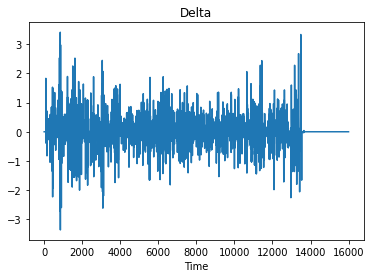

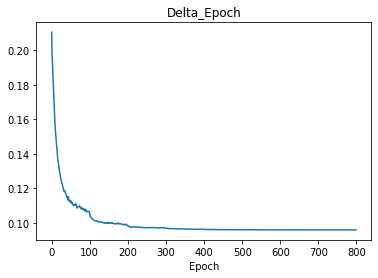

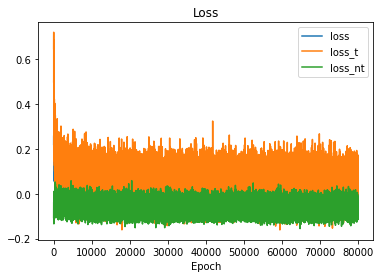

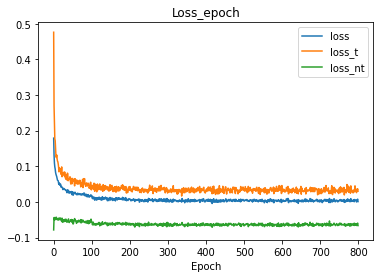

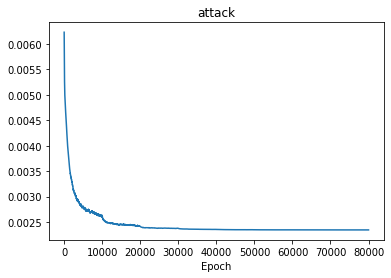

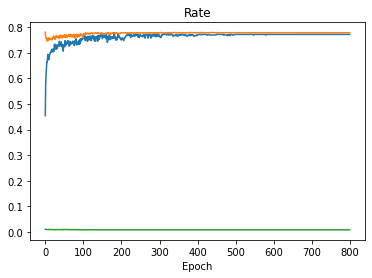

tensor([[ 1.0370e-08, -2.3902e-09,  8.8363e-11,  ...,  5.7769e-11,
         -2.0882e-09,  1.3691e-10]], grad_fn=<SqueezeBackward1>)


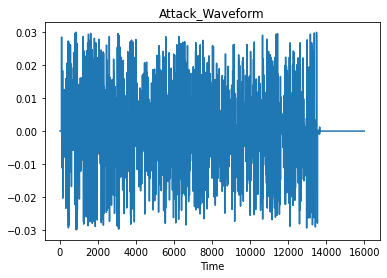

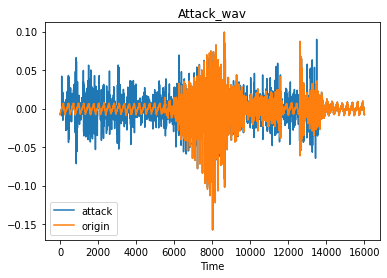


Test Epoch: 0	Attack_Accuracy: 318/412 (77%)


Test Epoch: 0	maintain_Accuracy: 8246/10593 (78%)



In [25]:

time_ = time.strftime('%d_%H_%M_%S',time.localtime(time.time()))
dir_path = os.path.join('output',time_)
os.mkdir(os.path.join('output',time_)) 

print(delta)
plt.plot(delta.squeeze().detach().to('cpu').numpy())
plt.xlabel("Time")
plt.title("Delta")
plt.savefig(os.path.join(dir_path,"Delta.png"), facecolor ="w" , edgecolor = "w") 
plt.show()
plt.close()
plt.plot(delta_sum)
plt.xlabel("Epoch")
plt.title("Delta_Epoch")
plt.savefig(os.path.join(dir_path,"Delta_Epoch.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
plt.plot(losses, label='loss')
plt.plot(losses_t, label='loss_t')
plt.plot(losses_nt, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss")
plt.savefig(os.path.join(dir_path,"Loss.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()

plt.plot(losses_epoch, label='loss')
plt.plot(losses_t_epoch, label='loss_t')
plt.plot(losses_nt_epoch, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss_epoch")
plt.savefig(os.path.join(dir_path,"Loss_epoch.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()

plt.plot(delta_wav)
plt.xlabel("Epoch")
plt.title("attack")
plt.savefig(os.path.join(dir_path,"Attack.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
plt.plot(attack_,label='attack')
plt.plot(maintain_,label='maintain')
plt.plot(error_,label='error')
plt.xlabel("Epoch")
plt.title("Rate")
plt.savefig(os.path.join(dir_path,"Rate.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
threshold = 0.1 + (n_epoch // threshold_epoch  -1 ) * 0.07

delta_ = threshold*torch.tanh(delta)
delta_ = delta_.to('cpu')
delta_ = torch.squeeze(delta_,0)

print(delta_)
plt.plot(torch.squeeze(delta_,0).detach().numpy())
plt.xlabel("Time")
plt.title("Attack_Waveform")
plt.savefig(os.path.join(dir_path,"Attack_Waveform.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
torchaudio.save(os.path.join(dir_path,"Attack.wav"), delta_ , sample_rate=16000, channels_first=True)


test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)

f = open(os.path.join(dir_path,"Parameter_2.txt"), "w")  # 打开文件
print("n_epoch=",n_epoch,file=f)
print("threshold_epoch=",threshold_epoch,file=f)
print("target:origin=1:0.5",file=f)

f.close()


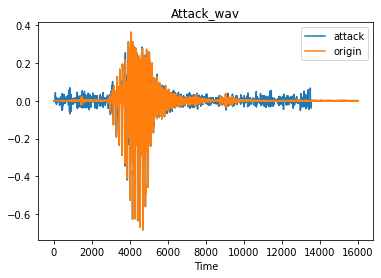


Test Epoch: 0	Attack_Accuracy: 318/412 (77%)


Test Epoch: 0	maintain_Accuracy: 8246/10593 (78%)


Test Epoch: 0	Attack_Accuracy: 28/412 (7%)


Test Epoch: 0	maintain_Accuracy: 9859/10593 (93%)



0.5

In [26]:
test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)
test_attack(model,0,threshold_epoch)

In [27]:
print(len(attack_train_loader))

15


Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




Conclusion
----------

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


